In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os.path as osp
import os
import numpy as np
import h5py

In [ ]:
Data_dir = "F:\\Data\\hw_5_train\\train_set.hdf5"
f = h5py.File(Data_dir, 'r')
train_data = f['data'][:]
train_label = f['label'][:]
f.close()

Data_dir = "F:\\Data\\hw_5_train\\val_set.hdf5"
f = h5py.File(Data_dir, 'r')
val_data = f['data'][:]
val_label = f['label'][:]
f.close()

Data_dir = "F:\\Data\\hw_5_train\\test_set.hdf5"
f = h5py.File(Data_dir, 'r')
test_data = f['data'][:]
test_label = f['label'][:]
f.close()

In [ ]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)
print(test_data.shape)
print(test_label.shape)

In [4]:
class Dataset(Dataset):
    def __init__(self, data, label):
        self.num_seq = data.shape[0]


        self.X = data
        self.Y = label
        
        
    def __len__(self):
        return self.num_seq
    
    
    def __getitem__(self, index):
        x = self.X[index:index+1]
        x = x.squeeze(0)    

        y = self.Y[index]
        return torch.Tensor(x), torch.Tensor(y)

In [5]:
train_dataset = Dataset(train_data,train_label)
val_dataset = Dataset(val_data,val_label)
test_dataset = Dataset(test_data,test_label)

batch_size=3
train_seq_length=train_data.shape[1]
num_feature=train_data.shape[2]
val_seq_length=val_data.shape[1]
test_seq_length = test_data.shape[1]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [2]:
hidden_size = 48
num_feature = 64

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
                
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        
        self.Linear1 = nn.Linear(self.input_size,self.input_size*2)
        self.relu = nn.ReLU()
        self.batch = nn.BatchNorm1d(1000)
        
        self.rnn = nn.GRU(self.input_size*2, self.hidden_size, batch_first=True,num_layers=4,dropout=0.4)
        
        self.Linear2 = nn.Linear(self.hidden_size, 32)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(32,3)
        
    # create function to init state
    def init_hidden(self, batch_size):
        return torch.zeros(4, batch_size, self.hidden_size)
        
    
    def forward(self, x):  
        x=self.Linear1(x)
        x=self.relu(x)
        x=self.batch(x)
        
        batch_size = x.size(0)
        
        
        h = self.init_hidden(batch_size).to(device)
        
        out, h = self.rnn(x, h)    
        
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        
        return out
        
    
model = Model(input_size=num_feature, hidden_size=hidden_size, output_size=3)

In [149]:
hidden_size = 48
num_feature = 64

class StreamModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StreamModel, self).__init__()
                
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        
        self.Linear1 = nn.Linear(self.input_size,self.input_size*2)
        self.relu = nn.ReLU()
        self.batch = nn.BatchNorm1d(train_seq_length)
        
        self.rnn = nn.GRU(self.input_size*2, self.hidden_size, batch_first=True,num_layers=4,dropout=0.4)
        
        self.Linear2 = nn.Linear(self.hidden_size, 32)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(32,3)
        
    # create function to init state
    def init_hidden(self, batch_size):
        return torch.zeros(4, batch_size, self.hidden_size)
        
    
    def forward(self, x):  
        x=self.Linear1(x)
        x=self.relu(x)
        
        batch_size = x.size(0)
        
        
        h = self.init_hidden(batch_size).to(device)
        
        out, h = self.rnn(x, h)    
        
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        
        return out
        
    
streammodel = StreamModel(input_size=num_feature, hidden_size=hidden_size, output_size=3)

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
model.to(device)

from pytorch_model_summary import summary
summary(
    model,
    torch.zeros(batch_size, train_seq_length, num_feature).to(device),
    show_input=True,
    print_summary=True
)

cuda:0
----------------------------------------------------------------------------------
      Layer (type)                    Input Shape         Param #     Tr. Param #
          Linear-1                  [3, 1000, 64]           8,320           8,320
            ReLU-2                 [3, 1000, 128]               0               0
     BatchNorm1d-3                 [3, 1000, 128]           2,000           2,000
             GRU-4     [3, 1000, 128], [4, 3, 48]          67,968          67,968
          Linear-5                  [3, 1000, 48]           1,568           1,568
         Dropout-6                  [3, 1000, 32]               0               0
          Linear-7                  [3, 1000, 32]              99              99
Total params: 79,955
Trainable params: 79,955
Non-trainable params: 0
----------------------------------------------------------------------------------


'----------------------------------------------------------------------------------\n      Layer (type)                    Input Shape         Param #     Tr. Param #\n==================================================================================\n          Linear-1                  [3, 1000, 64]           8,320           8,320\n            ReLU-2                 [3, 1000, 128]               0               0\n     BatchNorm1d-3                 [3, 1000, 128]           2,000           2,000\n             GRU-4     [3, 1000, 128], [4, 3, 48]          67,968          67,968\n          Linear-5                  [3, 1000, 48]           1,568           1,568\n         Dropout-6                  [3, 1000, 32]               0               0\n          Linear-7                  [3, 1000, 32]              99              99\n==================================================================================\nTotal params: 79,955\nTrainable params: 79,955\nNon-trainable params: 0\n----------

In [17]:
from tqdm import tqdm
import copy
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import os.path as osp


ts = datetime.now().strftime('%Y%m%d_%H%M%S')

loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999),
                               eps=1e-08, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)


for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.orthogonal_(m.weight)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

num_epochs = 30

for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0.0
    val_loss =0
    val_accuracy = 0.0
    
    if(epoch>19):
            scheduler.step()
    print(scheduler.get_last_lr())
    model.train()
    for x, y in tqdm(train_dataloader):
        
        
        x = x.to(device)
        y = y.to(torch.long).to(device)
        

        yhat = model(x)
        y=y.reshape(-1,1000)
        
        softmax=nn.Softmax(dim=2)
        pred = softmax(yhat).argmax(dim=2)
        train_accuracy+=(pred==y).sum()
        
        yhat = yhat.permute(0,2,1)
        
        loss = loss_func(yhat,y)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
    
    train_loss = train_loss / (len(train_dataloader.dataset)//batch_size)
    train_accuracy = train_accuracy / (len(train_dataloader.dataset)*train_seq_length)
    if not (epoch % 1):
        print(f'Epoch: {epoch+1:02d},  ' +
              f'TrainLoss: {train_loss :.4f}  '
              f'TrainAcc: {train_accuracy :.4f}')
    
    
    writer = SummaryWriter(f'C:\\Users\\msi\\JupyterProject\\EE599Homework\\Hw5\\tensorboard\\{ts}')
    writer.add_scalar('Loss/train',
                        train_loss,
                        epoch+1)

    writer.add_scalar('Accuracy/train',
                        train_accuracy,
                        epoch+1)
    writer.close()
    model.eval()
    for x, y in tqdm(val_dataloader):
        
        x = x.to(device)
        y = y.to(torch.long).to(device)
        
        with torch.no_grad():
            yhat = model(x)
        yhat = model(x)    
        y=y.reshape(-1,1000)
        
        softmax=nn.Softmax(dim=2)
        pred = softmax(yhat).argmax(dim=2)
        val_accuracy+=(pred==y).sum()
        
        yhat = yhat.permute(0,2,1)
        
        loss = loss_func(yhat,y)

        val_loss += loss
        
        
    val_loss = val_loss / (len(val_dataloader.dataset)//batch_size)
    val_accuracy = val_accuracy / (len(val_dataloader.dataset)*val_seq_length)
    if not (epoch % 1):
        print(f'Epoch: {epoch+1:02d},  ' +
              f'ValLoss: {val_loss:.4f}   '
              f'ValAcc: {val_accuracy:.4f}')

    writer = SummaryWriter(f'C:\\Users\\msi\\JupyterProject\\EE599Homework\\Hw5\\tensorboard\\{ts}')
    writer.add_scalar('Loss/val',
                        val_loss,
                        epoch+1)

    writer.add_scalar('Accuracy/val',
                        val_accuracy,
                        epoch+1)
    writer.close()
    
    if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

torch.save({
            'model': best_model_wts,
            }, 'MyNet.pth')
print('Model saved and the best accuracy is : {:.4f}'.format(best_acc))            


print('Finished Training')

  0%|          | 0/422 [00:00<?, ?it/s]

[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.92it/s]

Epoch: 01,  TrainLoss: 0.9575  TrainAcc: 0.5129


  0%|          | 1/422 [00:00<01:12,  5.77it/s]

Epoch: 01,  ValLoss: 1.0233   ValAcc: 0.4730
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.77it/s]

Epoch: 02,  TrainLoss: 0.8044  TrainAcc: 0.5914


  0%|          | 1/422 [00:00<01:10,  5.93it/s]

Epoch: 02,  ValLoss: 1.2147   ValAcc: 0.5203
[0.001]


  2%|▏         | 1/53 [00:00<00:05,  9.06it/s]

Epoch: 03,  TrainLoss: 0.6113  TrainAcc: 0.7352


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch: 03,  ValLoss: 0.9855   ValAcc: 0.6585
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.57it/s]

Epoch: 04,  TrainLoss: 0.4464  TrainAcc: 0.8244


  0%|          | 1/422 [00:00<01:09,  6.10it/s]

Epoch: 04,  ValLoss: 1.0039   ValAcc: 0.6782
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.60it/s]

Epoch: 05,  TrainLoss: 0.3521  TrainAcc: 0.8676


  0%|          | 1/422 [00:00<01:08,  6.15it/s]

Epoch: 05,  ValLoss: 0.9551   ValAcc: 0.6827
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.22it/s]

Epoch: 06,  TrainLoss: 0.2964  TrainAcc: 0.8903


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch: 06,  ValLoss: 1.1955   ValAcc: 0.6610
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.65it/s]

Epoch: 07,  TrainLoss: 0.2615  TrainAcc: 0.9035


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch: 07,  ValLoss: 1.1370   ValAcc: 0.6755
[0.001]


  2%|▏         | 1/53 [00:00<00:07,  7.43it/s]

Epoch: 08,  TrainLoss: 0.2640  TrainAcc: 0.9028


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch: 08,  ValLoss: 1.2104   ValAcc: 0.6632
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.77it/s]

Epoch: 09,  TrainLoss: 0.2298  TrainAcc: 0.9155


  0%|          | 1/422 [00:00<01:17,  5.45it/s]

Epoch: 09,  ValLoss: 1.0351   ValAcc: 0.6776
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.64it/s]

Epoch: 10,  TrainLoss: 0.2191  TrainAcc: 0.9196


  0%|          | 1/422 [00:00<01:11,  5.90it/s]

Epoch: 10,  ValLoss: 1.2817   ValAcc: 0.6869
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.09it/s]

Epoch: 11,  TrainLoss: 0.2114  TrainAcc: 0.9223


  0%|          | 1/422 [00:00<01:09,  6.08it/s]

Epoch: 11,  ValLoss: 1.1540   ValAcc: 0.6538
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.32it/s]

Epoch: 12,  TrainLoss: 0.2066  TrainAcc: 0.9243


  0%|          | 1/422 [00:00<01:06,  6.35it/s]

Epoch: 12,  ValLoss: 1.1933   ValAcc: 0.7081
[0.001]


  2%|▏         | 1/53 [00:00<00:07,  7.43it/s]

Epoch: 13,  TrainLoss: 0.1888  TrainAcc: 0.9305


  0%|          | 1/422 [00:00<01:07,  6.28it/s]

Epoch: 13,  ValLoss: 1.2671   ValAcc: 0.6658
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.36it/s]

Epoch: 14,  TrainLoss: 0.1874  TrainAcc: 0.9306


  0%|          | 1/422 [00:00<01:10,  5.97it/s]

Epoch: 14,  ValLoss: 1.3102   ValAcc: 0.7034
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.22it/s]

Epoch: 15,  TrainLoss: 0.1854  TrainAcc: 0.9318


  0%|          | 1/422 [00:00<01:09,  6.09it/s]

Epoch: 15,  ValLoss: 1.4016   ValAcc: 0.6532
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.22it/s]

Epoch: 16,  TrainLoss: 0.2639  TrainAcc: 0.9048


  0%|          | 1/422 [00:00<01:09,  6.04it/s]

Epoch: 16,  ValLoss: 1.4563   ValAcc: 0.6272
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.36it/s]

Epoch: 17,  TrainLoss: 0.1880  TrainAcc: 0.9311


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch: 17,  ValLoss: 1.5728   ValAcc: 0.6327
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  8.57it/s]

Epoch: 18,  TrainLoss: 0.1741  TrainAcc: 0.9359


  0%|          | 1/422 [00:00<01:10,  6.00it/s]

Epoch: 18,  ValLoss: 1.7234   ValAcc: 0.6358
[0.001]


  2%|▏         | 1/53 [00:00<00:06,  7.71it/s]

Epoch: 19,  TrainLoss: 0.1594  TrainAcc: 0.9410


  0%|          | 1/422 [00:00<01:08,  6.11it/s]

Epoch: 19,  ValLoss: 1.4202   ValAcc: 0.6687
[0.001]


  2%|▏         | 1/53 [00:00<00:07,  7.27it/s]

Epoch: 20,  TrainLoss: 0.1519  TrainAcc: 0.9441


  0%|          | 1/422 [00:00<01:07,  6.23it/s]

Epoch: 20,  ValLoss: 1.7687   ValAcc: 0.6444
[0.0009045084971874737]


 67%|██████▋   | 282/422 [01:18<00:39,  3.58it/s]


KeyboardInterrupt: 

In [99]:
model.load_state_dict(torch.load('C://Users//msi//JupyterProject//EE599Homework//Hw5//48features.pth')['model'])
streammodel.load_state_dict(torch.load('C://Users//msi//JupyterProject//EE599Homework//Hw5//48features.pth')['model'])

<All keys matched successfully>

In [73]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
model.to(device)

model.eval()
loss_func = nn.CrossEntropyLoss()

val_loss =0
val_accuracy = 0.0
for x, y in tqdm(val_dataloader):
        
    x = x.to(device)
    y = y.to(torch.long).to(device)
        
    with torch.no_grad():
        yhat = model(x)
    yhat = model(x)    
    y=y.reshape(-1,1000)
        
    softmax=nn.Softmax(dim=2)
    pred = softmax(yhat).argmax(dim=2)
    val_accuracy+=(pred==y).sum()
        
    yhat = yhat.permute(0,2,1)
        
    loss = loss_func(yhat,y)

    val_loss += loss
        
        
val_loss = val_loss / (len(val_dataloader.dataset)//batch_size)
val_accuracy = val_accuracy / (len(val_dataloader.dataset)*val_seq_length)
print(val_loss)
print(val_accuracy)

# test_loss =0
# test_accuracy = 0.0
# for x, y in tqdm(test_dataloader):
        
#     x = x.to(device)
#     y = y.to(torch.long).to(device)
        
#     with torch.no_grad():
#         yhat = model(x)
#     yhat = model(x)    
#     y=y.reshape(-1,1000)
        
#     softmax=nn.Softmax(dim=2)
#     pred = softmax(yhat).argmax(dim=2)
#     test_accuracy+=(pred==y).sum()
        
#     yhat = yhat.permute(0,2,1)
        
#     loss = loss_func(yhat,y)

#     test_loss += loss
        
        
# test_loss = test_loss / (len(test_dataloader.dataset)//batch_size)
# test_accuracy = test_accuracy / (len(test_dataloader.dataset)*test_seq_length)
# print(test_loss)
# print(test_accuracy)

  0%|          | 0/528 [00:00<?, ?it/s]

cuda:0


  8%|▊         | 42/528 [00:04<00:49,  9.76it/s]


KeyboardInterrupt: 

In [139]:
import librosa
import os.path as osp
import os
import numpy as np
import h5py
from tqdm import tqdm
import random


English = "F:\\Data\\hw_5_train\\train_english"
Chinese = "F:\\Data\\hw_5_train\\train_mandarin"
Hindi   = "F:\\Data\\hw_5_train\\train_hindi"

M = 1000
threshold = 30

eng_dir = os.listdir(English)
eng_feature = np.zeros((1,64))

y, sr = librosa.load(osp.join(English, 'english_0001.wav'), sr=16000)
intervals = librosa.effects.split(y, top_db=threshold)
y_new = np.zeros((1))
for interval in intervals:
    y_new = np.concatenate((y_new, y[interval[0]: interval[1]]))
y = y_new[1:]
mat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft=int(sr*0.025), hop_length=int(sr*0.010))
mat = mat.T
eng_feature=np.concatenate([eng_feature,mat],axis=0)

eng_feature=eng_feature[1:]
eng_label = 0*np.ones((eng_feature.shape[0],1))

print(eng_feature.shape)
print(eng_label.shape)

(43748, 64)
(43748, 1)


In [140]:
eng_feature=np.reshape(eng_feature[:1000],(1,-1,64))
print(eng_feature.shape)
eng_label = np.reshape(eng_label[:1000], (1,-1, 1))
print(eng_label.shape)

(1, 1000, 64)
(1, 1000, 1)


In [141]:
english0003=Dataset(eng_feature,eng_label)
eng_0003 = DataLoader(english0003, batch_size=1)

In [142]:
pred=[]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
model.to(device)
for x, y in tqdm(eng_0003):
  
    x = x.to(device)
    y = y.to(torch.long).to(device)
        
    with torch.no_grad():
        yhat = model(x)
    yhat = model(x)    
    y=y.reshape(-1,1)
        
    softmax=nn.Softmax(dim=2)
    pred.append(softmax(yhat).cpu().data.numpy())

  0%|          | 0/1 [00:00<?, ?it/s]

cuda:0


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


In [143]:
pred=np.asarray(pred) 
print(pred.shape)

(1, 1, 1000, 3)


In [144]:
pred=pred.reshape(-1,3)

In [145]:
final = np.mean(pred,axis=0)
print(final)

[0.9291607  0.00966052 0.06117951]


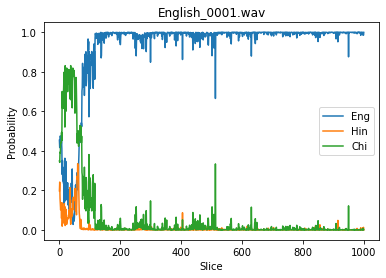

In [147]:
import matplotlib.pyplot as plt
plt.plot(pred[:, 0], label='Eng')
plt.plot(pred[:, 1], label='Hin')
plt.plot(pred[:, 2], label='Chi')
plt.title('English_0001.wav')
plt.ylabel('Probability')
plt.xlabel('Slice')
plt.legend()

In [7]:
from torchviz import make_dot, make_dot_from_trace

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
model.to(device)
x = torch.zeros(1,1000,64, dtype=torch.float, requires_grad=False)
x = x.to(device)
out = model(x)
dot = make_dot(out)
dot.format = 'png'
dot.render("streamming-model")

cuda:0


'streamming-model.png'